### Imports

In [12]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

from cca_algorithms import bio_cca, gen_oja, msg_cca, asy_cca, bio_rrr
from util import correlation_matrix, obj_error, msg_error, subspace_error, constraint_error, add_fill_lines

### Load dataset

In [13]:
# select the desired dataset and number of epochs

dataset = 'synthetic'; epochs = 1
# dataset = 'mediamill'; epochs = 3

# load dataset

X = np.load(f'datasets/{dataset}/view1.npy')
Y = np.load(f'datasets/{dataset}/view2.npy')

# dataset dimensions

x_dim = X.shape[0]
y_dim = Y.shape[0]
samples = X.shape[1]

### Offline solution

In [14]:
# Covariance matrices

Cxx = X@X.T/samples
Cyy = Y@Y.T/samples
Cxy = X@Y.T/samples

# Inverse matrices

sig_y, Uy = np.linalg.eig(Cyy)

Cyy_inv = Uy@np.diag(1./sig_y)@Uy.T

# Correlation matrix

Rxy = correlation_matrix(Cxx, Cyy, Cxy)

# SVD

u, canonical_correlations, vh = np.linalg.svd(Rxy)

### Parameters

In [42]:
trials = 1; z_dim = 4; iters = epochs*samples; training_samples = 1000

In [43]:
# Maximum of the objective

max_obj = sum(canonical_correlations[:z_dim])/2

In [44]:
# Optimal subspace projections

Ux = u[:,:z_dim]
Uy = vh.T[:,:z_dim]

Px_opt = Ux@np.linalg.inv(Ux.T@Ux)@Ux.T
Py_opt = Uy@np.linalg.inv(Uy.T@Uy)@Uy.T

### Bio-RRR

In [45]:
# Grid

eta0_list = [1e-2,1e-3]
eta_decay_list = [1e-4,1e-5,1e-6]
tau_list = [1e2,1e1]

In [46]:
biorrr_error = {}

for eta0 in eta0_list:
    
    biorrr_error[eta0] = {}
    
    for eta_decay in eta_decay_list:
        
        biorrr_error[eta0][eta_decay] = {}
        
        for tau in tau_list:
            
            biorrr_error[eta0][eta_decay][tau] = np.zeros((trials,iters))

In [47]:
for eta0 in eta0_list:
    
    for eta_decay in eta_decay_list:
        
        for tau in tau_list:
            
            print(f'eta(t): {eta0}/(1+{eta_decay}*t), tau: {tau}')

            for i_trial in range(trials):

                print(f'Trial {i_trial+1} out of {trials}:')

                # Initialize Bio-RRR
                
                def step_x(t):
                    return eta0/(1+eta_decay*t)
                
                def step_y(t):
                    return step_x(t)/tau

                biorrr = bio_rrr(z_dim,x_dim,y_dim,eta_x=step_x,eta_y=step_y,eta_q=step_y)   
                biorrr_Vx = np.zeros((iters,x_dim,z_dim))
                biorrr_Vy = np.zeros((iters,y_dim,z_dim))

                # Run Bio-CCA
                
                print('Running Bio-RRR...')

                for i_epoch in range(epochs):

                    print(f'Epoch {i_epoch+1} out of {epochs}:')

                    # Random permutation of the inputs

                    idx = np.random.permutation(samples)

                    # Online updates

                    for i_sample in range(samples):

                        i_iter = i_epoch*samples + i_sample

                        x = X[:,idx[i_sample]]
                        y = Y[:,idx[i_sample]]

                        # online updates

                        biorrr_Vx[i_iter], biorrr_Vy[i_iter] = biorrr.fit_next(x,y)
                        
                # Compute error

                print('Computing errors...')

                for i_iter in range(iters):
                    biorrr_error[eta0][eta_decay][tau][i_trial,i_iter] = subspace_error(biorrr_Vx[i_iter], Px_opt)
                    
                print(f'Average error: {np.mean(biorrr_error[eta0][eta_decay][tau][i_trial,-10000:])}')

            # save data 

            pkl.dump(biorrr_error, open(f'error/grid/biorrr_{dataset}_{z_dim}-dim_error.p', 'wb'))
            
print('Grid search complete')

eta(t): 0.01/(1+0.0001*t), tau: 100.0
Trial 1 out of 1:
Running Bio-RRR...
Epoch 1 out of 1:
Computing errors...
Average error: 4.253293251931832
eta(t): 0.01/(1+0.0001*t), tau: 10.0
Trial 1 out of 1:
Running Bio-RRR...
Epoch 1 out of 1:
Computing errors...
Average error: 4.258110088894044
eta(t): 0.01/(1+1e-05*t), tau: 100.0
Trial 1 out of 1:
Running Bio-RRR...
Epoch 1 out of 1:
Computing errors...
Average error: 4.252326385153917
eta(t): 0.01/(1+1e-05*t), tau: 10.0
Trial 1 out of 1:
Running Bio-RRR...
Epoch 1 out of 1:
Computing errors...
Average error: 4.255953348122667
eta(t): 0.01/(1+1e-06*t), tau: 100.0
Trial 1 out of 1:
Running Bio-RRR...
Epoch 1 out of 1:
Computing errors...
Average error: 4.262427287424303
eta(t): 0.01/(1+1e-06*t), tau: 10.0
Trial 1 out of 1:
Running Bio-RRR...
Epoch 1 out of 1:
Computing errors...
Average error: 4.249744635620806
eta(t): 0.001/(1+0.0001*t), tau: 100.0
Trial 1 out of 1:
Running Bio-RRR...
Epoch 1 out of 1:
Computing errors...
Average error: 6.

In [48]:
# Grid

eta0_list = [1e-2,1e-3]
eta_decay_list = [1e-4,1e-5,1e-6]
tau_list = [1e2,1e1]

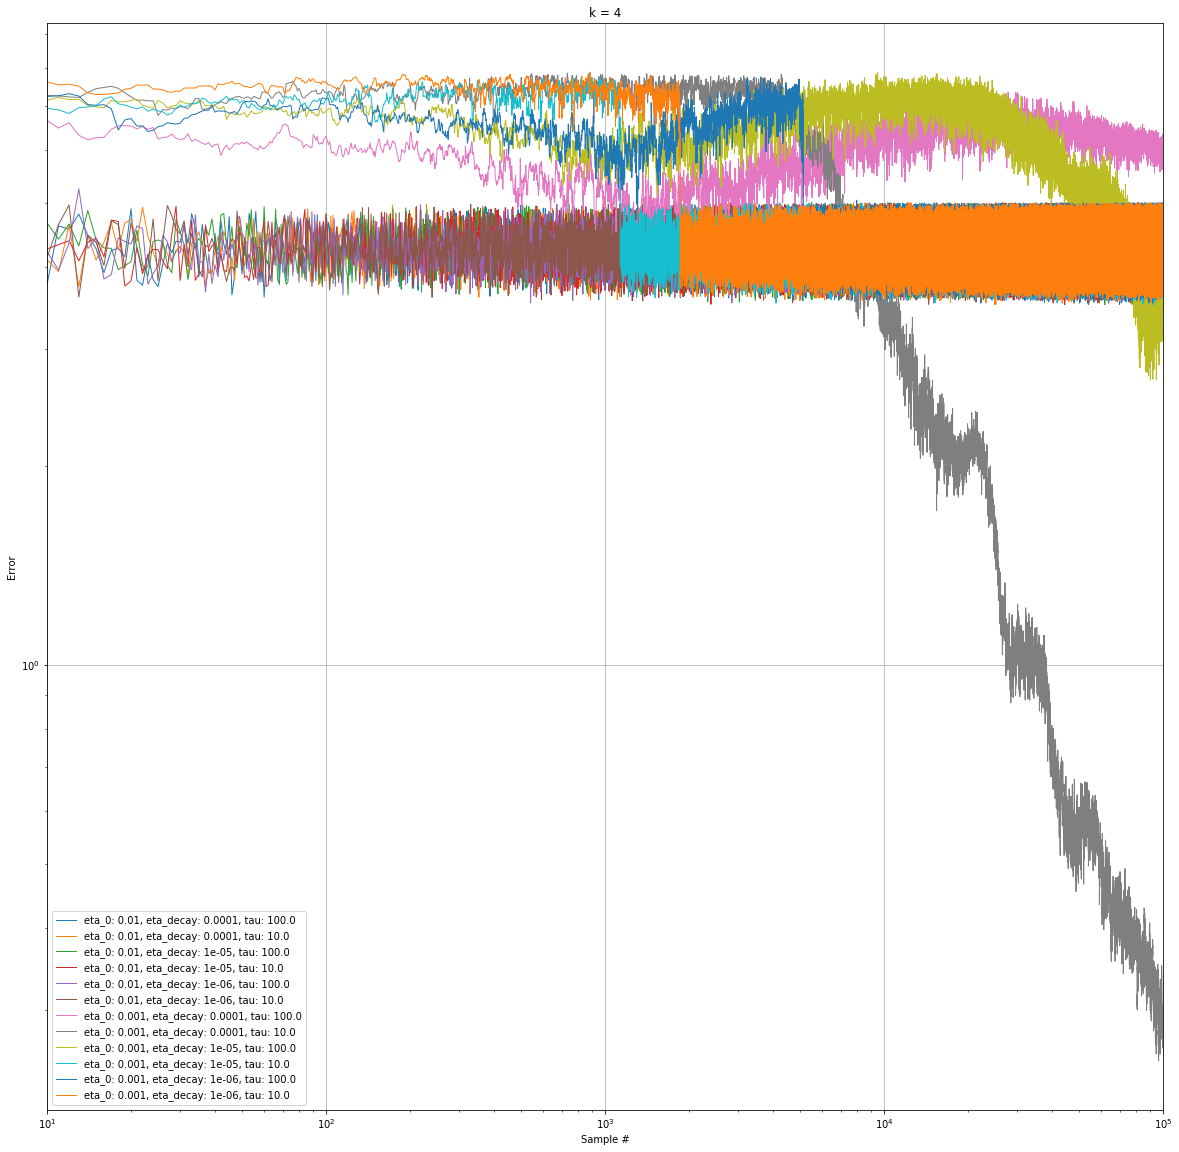

In [49]:
linewidth = 1

t = list(range(iters))

fig = plt.figure(figsize=(20,20))

ax = plt.subplot(1, 1, 1)

for eta0 in eta0_list:
    for eta_decay in eta_decay_list:
        for tau in tau_list:
            add_fill_lines(ax, t, biorrr_error[eta0][eta_decay][tau], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': f'eta_0: {eta0}, eta_decay: {eta_decay}, tau: {tau}'})

ax.loglog()

plt.title(f"k = {z_dim}")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlim((1e1,iters))
plt.xlabel('Sample #')
plt.ylabel('Error')
plt.show()